# Module 4: Raster Data Analysis for H&H Modeling
## Understanding How Water Moves Across the Landscape 🏔️

### Welcome to Raster Analysis!
This module introduces **raster (gridded) data analysis** - essential for understanding **how** water moves across terrain and **what** it encounters. We'll work with elevation and land cover data to complete your spatial analysis toolkit.

### What You'll Accomplish Today:
✅ Understand raster data as "smart grids" with values  
✅ Load and visualize Digital Elevation Models (DEMs)  
✅ Analyze land cover patterns using NLCD data  
✅ Clip rasters to watershed boundaries  
✅ Calculate terrain and land use statistics  
✅ Create elevation bands and slope maps  
✅ Answer: "How does terrain affect runoff?" "What land uses dominate?"  

### Module Structure:
1. **Mental Models** - Raster vs Vector thinking
2. **Raster Basics** - Pixels, bands, and values
3. **Loading Raster Data** - DEMs and Land Cover
4. **Clipping to Watersheds** - Focus your analysis
5. **Elevation Analysis** - Terrain statistics
6. **Land Cover Analysis** - Understanding the surface
7. **Raster Calculations** - Slope, aspect, and more
8. **Professional Visualization** - Maps that communicate
9. **What You Can Now Do** - Complete spatial toolkit

---

## Part 1: Mental Models - Thinking in Grids 🧠

### Raster Data: The Landscape as a Grid

**Think of raster data like a spreadsheet covering the Earth:**
- Each cell (pixel) has a value
- Values represent measurements (elevation, rainfall, temperature)
- Cells are uniformly sized and aligned
- Perfect for continuous phenomena

### Vector vs Raster: Two Ways to See the World

| Aspect | Vector (Module 3) | Raster (Module 4) |
|--------|------------------|-------------------|
| **Structure** | Points, lines, polygons | Grid of cells |
| **Best for** | Discrete features | Continuous surfaces |
| **H&H Examples** | Watersheds, pipes, buildings | Elevation, precipitation, land cover |
| **Question answered** | WHERE are things? | HOW does it vary? |

### Today's Engineering Questions

For HUC-12 watershed 101900090108:
1. **What's the terrain like?** → Elevation statistics
2. **How steep is it?** → Slope calculations
3. **What land covers exist?** → NLCD analysis
4. **How does land use affect runoff?** → Curve number assignment

### Key Concepts

**Resolution**: Size of each pixel (e.g., 10m x 10m)
- Higher resolution = smaller pixels = more detail
- Trade-off: Detail vs file size

**Bands**: Layers of information
- DEM: Single band (elevation)
- Land cover: Single band (class codes)
- Satellite imagery: Multiple bands (RGB, infrared)

**NoData**: Pixels with no value
- Outside study area
- Missing measurements
- Must handle in calculations

### The Power of Combining Vector + Raster

**Module 3 (Vector)** told us WHERE the watershed is  
**Module 4 (Raster)** tells us WHAT'S INSIDE and HOW it behaves

Together = Complete spatial understanding for H&H modeling!

## Part 2: Setting Up Our Raster Workspace 🛠️

### Installing Required Libraries

For raster work, we need specialized tools:
- **Rasterio**: Reading/writing raster data
- **Rioxarray**: Raster operations with xarray
- **Rasterstats**: Zonal statistics
- **GeoPandas**: For vector boundaries

In [1]:
# Install raster analysis libraries
!pip install -q rasterio rioxarray rasterstats geopandas folium

print("✅ Raster libraries installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.9 MB/s eta 0:00:00
✅ Raster libraries installed!


In [2]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import rioxarray as rxr
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import folium
import warnings
warnings.filterwarnings('ignore')

# Set default plot size
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")
print(f"Rasterio version: {rasterio.__version__}")

Libraries imported successfully!
Rasterio version: 1.4.4


### Understanding Our Data Files

We'll work with three Wyoming datasets:

1. **Digital Elevation Model (DEM)**
   - File: `USGS_13_n42w105_2021061_DEM.tif`
   - Contains: Elevation values in meters
   - Use: Terrain analysis, slope, flow direction

2. **National Land Cover Database (NLCD)**
   - File: `NLCD2024.tif`
   - Contains: Land use/land cover classes
   - Use: Curve numbers, imperviousness

3. **Watershed Boundaries** (from Module 3)
   - File: `NHD__Watershed_Boundaries_HUC_12_Selected.zip`
   - Contains: HUC-12 polygons
   - Use: Clipping boundary

## Part 3: Loading Data into Colab 📁

Upload your raster and vector files:

In [4]:
# Upload files to Colab
from google.colab import files

print("📤 Please upload these files:")
print("1. USGS_13_n42w105_2021061_DEM.tif (Digital Elevation Model)")
print("2. NLCD2024.tif (Land Cover)")
print("3. NHD__Watershed_Boundaries_HUC_12_Selected.zip (Watersheds)")
print("\nClick 'Choose Files' below and select all three files...")

uploaded = files.upload()

print(f"\n✅ Uploaded {len(uploaded)} files:")
for filename in uploaded.keys():
    print(f"   - {filename}")

📤 Please upload these files:
1. USGS_13_n42w105_2021061_DEM.tif (Digital Elevation Model)
2. NLCD2024.tif (Land Cover)
3. NHD__Watershed_Boundaries_HUC_12_Selected.zip (Watersheds)

Click 'Choose Files' below and select all three files...


Saving NHD__Watershed_Boundaries_HUC_12_Selected.zip to NHD__Watershed_Boundaries_HUC_12_Selected (1).zip
Saving NLCD2024.tif to NLCD2024.tif
Saving USGS_13_n42w105_2021061_DEM.tif to USGS_13_n42w105_2021061_DEM.tif

✅ Uploaded 3 files:
   - NHD__Watershed_Boundaries_HUC_12_Selected (1).zip
   - NLCD2024.tif
   - USGS_13_n42w105_2021061_DEM.tif


## Part 4: Loading and Exploring Raster Data 🗺️

### Reading the Digital Elevation Model

In [5]:
# Open and explore the DEM
dem_path = 'USGS_13_n42w105_2021061_DEM.tif'

with rasterio.open(dem_path) as src:
    print("DEM PROPERTIES")
    print("="*40)
    print(f"Dimensions: {src.width} x {src.height} pixels")
    print(f"Number of bands: {src.count}")
    print(f"Coordinate system: {src.crs}")
    print(f"Pixel size: {src.res[0]:.2f} x {src.res[1]:.2f} {src.crs.linear_units}")
    print(f"Bounds: {src.bounds}")
    print(f"Data type: {src.dtypes[0]}")

    # Read the elevation data
    dem_data = src.read(1)  # Read first (and only) band
    dem_transform = src.transform
    dem_crs = src.crs

print(f"\nElevation range: {dem_data.min():.1f} to {dem_data.max():.1f} meters")
print(f"Mean elevation: {dem_data.mean():.1f} meters")

DEM PROPERTIES
Dimensions: 2041 x 1061 pixels
Number of bands: 1
Coordinate system: EPSG:4269
Pixel size: 0.00 x 0.00 unknown
Bounds: BoundingBox(left=-104.91203703717991, bottom=41.0402777771842, right=-104.72305555549514, top=41.13851851803062)
Data type: float32

Elevation range: -999999.0 to 1963.7 meters
Mean elevation: -316333.4 meters


### Quick Visualization of DEM

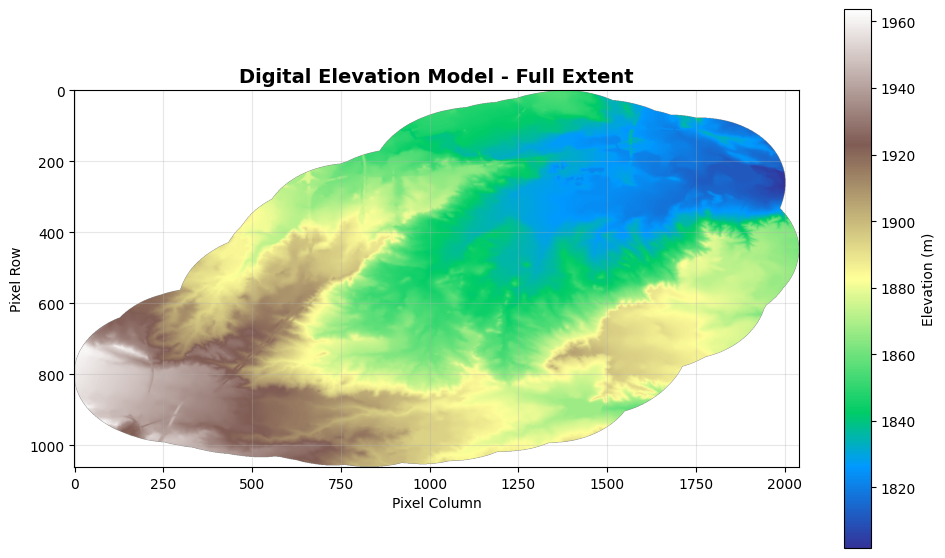

In [10]:
# Visualize the DEM
fig, ax = plt.subplots(figsize=(10, 8))

# Mask NoData values before plotting
dem_display = np.ma.masked_where(dem_data == -999999.0, dem_data)

# Plot with hillshade effect
im = ax.imshow(dem_display, cmap='terrain', aspect='equal')
plt.colorbar(im, ax=ax, label='Elevation (m)', shrink=0.7)

ax.set_title('Digital Elevation Model - Full Extent', fontsize=14, fontweight='bold')
ax.set_xlabel('Pixel Column')
ax.set_ylabel('Pixel Row')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Reading the Land Cover Data

In [11]:
# Open and explore NLCD
nlcd_path = 'NLCD2024.tif'

with rasterio.open(nlcd_path) as src:
    print("NLCD PROPERTIES")
    print("="*40)
    print(f"Dimensions: {src.width} x {src.height} pixels")
    print(f"Coordinate system: {src.crs}")
    print(f"Pixel size: {src.res[0]:.2f} x {src.res[1]:.2f} {src.crs.linear_units}")
    print(f"Bounds: {src.bounds}")

    # Read the land cover data
    nlcd_data = src.read(1)
    nlcd_transform = src.transform
    nlcd_crs = src.crs

# Get unique land cover values
unique_values = np.unique(nlcd_data[nlcd_data > 0])  # Exclude 0 (NoData)
print(f"\nUnique land cover codes: {unique_values}")
print(f"Number of land cover classes: {len(unique_values)}")

NLCD PROPERTIES
Dimensions: 535 x 354 pixels
Coordinate system: PROJCS["AEA_WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Pixel size: 30.00 x 30.00 metre
Bounds: BoundingBox(left=-741915.0, bottom=2037675.0, right=-725865.0, top=2048295.0)

Unique land cover codes: [ 11  21  22  23  24  31  52  71  81  82  90  95 250]
Number of land cover classes: 13


### Define NLCD Classification Scheme

In [12]:
# NLCD Classification codes and descriptions
nlcd_classes = {
    11: 'Open Water',
    12: 'Perennial Ice/Snow',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity',
    31: 'Barren Land',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous',
    81: 'Pasture/Hay',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands'
}

# Colors for visualization (standard NLCD colors)
nlcd_colors = {
    11: '#466B9F',  # Open Water - Blue
    12: '#D1DEF8',  # Ice/Snow - Light blue
    21: '#DEC5C5',  # Developed Open - Light pink
    22: '#D99282',  # Developed Low - Light red
    23: '#EB0000',  # Developed Medium - Red
    24: '#AB0000',  # Developed High - Dark red
    31: '#B3AC9F',  # Barren - Gray
    41: '#68AB5F',  # Deciduous - Light green
    42: '#1C5F2C',  # Evergreen - Dark green
    43: '#B5C58F',  # Mixed Forest - Yellow-green
    52: '#CCB879',  # Shrub - Tan
    71: '#DFDFC2',  # Grassland - Light yellow
    81: '#D1D182',  # Pasture - Yellow
    82: '#A3CC51',  # Crops - Light green
    90: '#82BA9E',  # Woody Wetlands - Teal
    95: '#DCCCC0'   # Herbaceous Wetlands - Light brown
}

print("NLCD land cover classes loaded:")
for code, desc in nlcd_classes.items():
    if code in unique_values:
        print(f"  {code}: {desc}")

NLCD land cover classes loaded:
  11: Open Water
  21: Developed, Open Space
  22: Developed, Low Intensity
  23: Developed, Medium Intensity
  24: Developed, High Intensity
  31: Barren Land
  52: Shrub/Scrub
  71: Grassland/Herbaceous
  81: Pasture/Hay
  82: Cultivated Crops
  90: Woody Wetlands
  95: Emergent Herbaceous Wetlands


## Part 5: Loading Watershed Boundaries 🗂️

We'll use the same watershed from Module 3:

In [13]:
# Load watershed boundaries
watersheds = gpd.read_file('zip://NHD__Watershed_Boundaries_HUC_12_Selected.zip')

print(f"Loaded {len(watersheds)} watersheds")
print(f"CRS: {watersheds.crs}")

# Find our target watershed (same as Module 3)
target_huc = '101900090108'

# Find HUC column
huc_column = None
for col in watersheds.columns:
    if 'huc' in col.lower() or 'HUC' in col:
        huc_column = col
        break

if huc_column:
    target_watershed = watersheds[watersheds[huc_column] == target_huc]
    if len(target_watershed) > 0:
        print(f"\n✅ Found target watershed: {target_huc}")
    else:
        print(f"⚠️ Watershed {target_huc} not found. Using first watershed.")
        target_watershed = watersheds.iloc[[0]]
else:
    print("⚠️ No HUC column found. Using first watershed.")
    target_watershed = watersheds.iloc[[0]]

# Display watershed info
print(f"\nTarget watershed properties:")
for col in target_watershed.columns:
    if col != 'geometry':
        print(f"  {col}: {target_watershed[col].values[0]}")

Loaded 19 watersheds
CRS: EPSG:3857

✅ Found target watershed: 101900090108

Target watershed properties:
  OBJECTID_1: 432
  TNMID: {0033630A-499B-4BB8-B14E-8E5764ED7848}
  MetaSource: {FF24B7E9-B918-4635-ADDB-267C27FDD7E0}
  SourceData: None
  SourceOrig: None
  SourceFeat: None
  LoadDate: 2017-07-20T00:00:00.000
  GNIS_ID: 0
  AreaAcres: 12016.58
  AreaSqKm: 48.63
  States: WY
  HUC12: 101900090108
  Name: Town of South Greeley
  HUType: S
  HUMod: NM
  ToHUC: 101900090109
  NonContrib: 0.0
  NonContr_1: 0.0
  Shape_Leng: 46158.0293969
  Shape_Area: 85681954.8029


## Part 6: Aligning Coordinate Systems 🌍

Critical step: Ensure all data uses the same CRS!

In [14]:
# Check and align CRS
print("Current Coordinate Reference Systems:")
print(f"  DEM: {dem_crs}")
print(f"  NLCD: {nlcd_crs}")
print(f"  Watersheds: {watersheds.crs}")

# Reproject watershed to match DEM CRS
if watersheds.crs != dem_crs:
    print(f"\n📐 Reprojecting watershed to match DEM CRS...")
    target_watershed = target_watershed.to_crs(dem_crs)
    print("✅ All data now in same coordinate system!")
else:
    print("\n✅ All data already in same coordinate system!")

Current Coordinate Reference Systems:
  DEM: EPSG:4269
  NLCD: PROJCS["AEA_WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  Watersheds: EPSG:3857

📐 Reprojecting watershed to match DEM CRS...
✅ All data now in same coordinate system!


## Part 7: Clipping Rasters to Watershed 🔧

### The Engineering Question

**"What are the terrain and land cover characteristics within our watershed?"**

We'll clip both rasters to focus on our area of interest.

### Clip the DEM

In [17]:
# Clip DEM to watershed boundary
from rasterio.mask import mask
import json

# Get watershed geometry
watershed_geom = target_watershed.geometry.iloc[0]

# Clip the DEM
with rasterio.open(dem_path) as src:
    # Perform the clip
    dem_clipped, dem_clip_transform = mask(
        src,
        [watershed_geom], # Pass the shapely geometry directly in a list
        crop=True,
        nodata=-9999
    )

    # Update metadata for clipped raster
    dem_clip_meta = src.meta.copy()
    dem_clip_meta.update({
        'height': dem_clipped.shape[1],
        'width': dem_clipped.shape[2],
        'transform': dem_clip_transform,
        'nodata': -9999
    })

# Extract the data array (first band)
dem_clipped_data = dem_clipped[0]

# Mask NoData values
dem_clipped_masked = np.ma.masked_where(dem_clipped_data == -9999, dem_clipped_data)

print(f"DEM clipped to watershed:")
print(f"  Original size: {dem_data.shape}")
print(f"  Clipped size: {dem_clipped_data.shape}")
print(f"  Valid pixels: {(~dem_clipped_masked.mask).sum():,}")

DEM clipped to watershed:
  Original size: (1061, 2041)
  Clipped size: (703, 1569)
  Valid pixels: 607,809


### Clip the Land Cover

In [19]:
# Clip NLCD to watershed boundary
with rasterio.open(nlcd_path) as src:
    # First reproject watershed to NLCD CRS if needed
    watershed_for_nlcd = target_watershed.to_crs(src.crs)
    # Directly get the shapely geometry object for clipping, avoiding JSON serialization issue
    watershed_geom_nlcd = watershed_for_nlcd.geometry.iloc[0]

    # Perform the clip
    nlcd_clipped, nlcd_clip_transform = mask(
        src,
        [watershed_geom_nlcd],
        crop=True,
        nodata=0
    )

    # Update metadata
    nlcd_clip_meta = src.meta.copy()
    nlcd_clip_meta.update({
        'height': nlcd_clipped.shape[1],
        'width': nlcd_clipped.shape[2],
        'transform': nlcd_clip_transform,
        'nodata': 0
    })

# Extract the data array
nlcd_clipped_data = nlcd_clipped[0]

print(f"NLCD clipped to watershed:")
print(f"  Original size: {nlcd_data.shape}")
print(f"  Clipped size: {nlcd_clipped_data.shape}")
print(f"  Valid pixels: {(nlcd_clipped_data > 0).sum():,}")

NLCD clipped to watershed:
  Original size: (354, 535)
  Clipped size: (231, 414)
  Valid pixels: 54,044


## Part 8: Elevation Analysis 📊

### Calculate Elevation Statistics

In [20]:
# Calculate elevation statistics
valid_elevations = dem_clipped_masked[~dem_clipped_masked.mask]

print("ELEVATION STATISTICS FOR WATERSHED")
print("="*50)
print(f"Minimum elevation: {valid_elevations.min():.1f} m ({valid_elevations.min()*3.281:.1f} ft)")
print(f"Maximum elevation: {valid_elevations.max():.1f} m ({valid_elevations.max()*3.281:.1f} ft)")
print(f"Mean elevation: {valid_elevations.mean():.1f} m ({valid_elevations.mean()*3.281:.1f} ft)")
print(f"Median elevation: {np.median(valid_elevations):.1f} m")
print(f"Standard deviation: {valid_elevations.std():.1f} m")
print(f"\nElevation range: {valid_elevations.max() - valid_elevations.min():.1f} m")
print(f"Relief ratio: {(valid_elevations.max() - valid_elevations.min())/1000:.3f} m/km")

ELEVATION STATISTICS FOR WATERSHED
Minimum elevation: 1811.7 m (5944.1 ft)
Maximum elevation: 1943.8 m (6377.5 ft)
Mean elevation: 1860.1 m (6103.1 ft)
Median elevation: 1854.8 m
Standard deviation: 27.4 m

Elevation range: 132.1 m
Relief ratio: 0.132 m/km


### Create Elevation Bands

In [21]:
# Define elevation bands for visualization and analysis
n_bands = 5
band_edges = np.linspace(valid_elevations.min(), valid_elevations.max(), n_bands + 1)

# Create elevation band raster
elevation_bands = np.zeros_like(dem_clipped_masked)
for i in range(n_bands):
    mask_band = (dem_clipped_masked >= band_edges[i]) & (dem_clipped_masked < band_edges[i+1])
    elevation_bands[mask_band] = i + 1

# Calculate area per band
print("\nELEVATION BANDS")
print("="*50)

# Assuming 10m resolution (adjust based on actual DEM)
pixel_area_m2 = 10 * 10  # Adjust this based on actual resolution

for i in range(n_bands):
    band_pixels = (elevation_bands == i + 1).sum()
    band_area_km2 = (band_pixels * pixel_area_m2) / 1_000_000
    band_percent = (band_pixels / (elevation_bands > 0).sum()) * 100

    print(f"Band {i+1}: {band_edges[i]:.0f} - {band_edges[i+1]:.0f} m")
    print(f"  Area: {band_area_km2:.2f} km² ({band_percent:.1f}%)")


ELEVATION BANDS
Band 1: 1812 - 1838 m
  Area: 14.34 km² (23.6%)
Band 2: 1838 - 1865 m
  Area: 23.62 km² (38.9%)
Band 3: 1865 - 1891 m
  Area: 13.86 km² (22.8%)
Band 4: 1891 - 1917 m
  Area: 6.43 km² (10.6%)
Band 5: 1917 - 1944 m
  Area: 2.53 km² (4.2%)


### Visualize Elevation

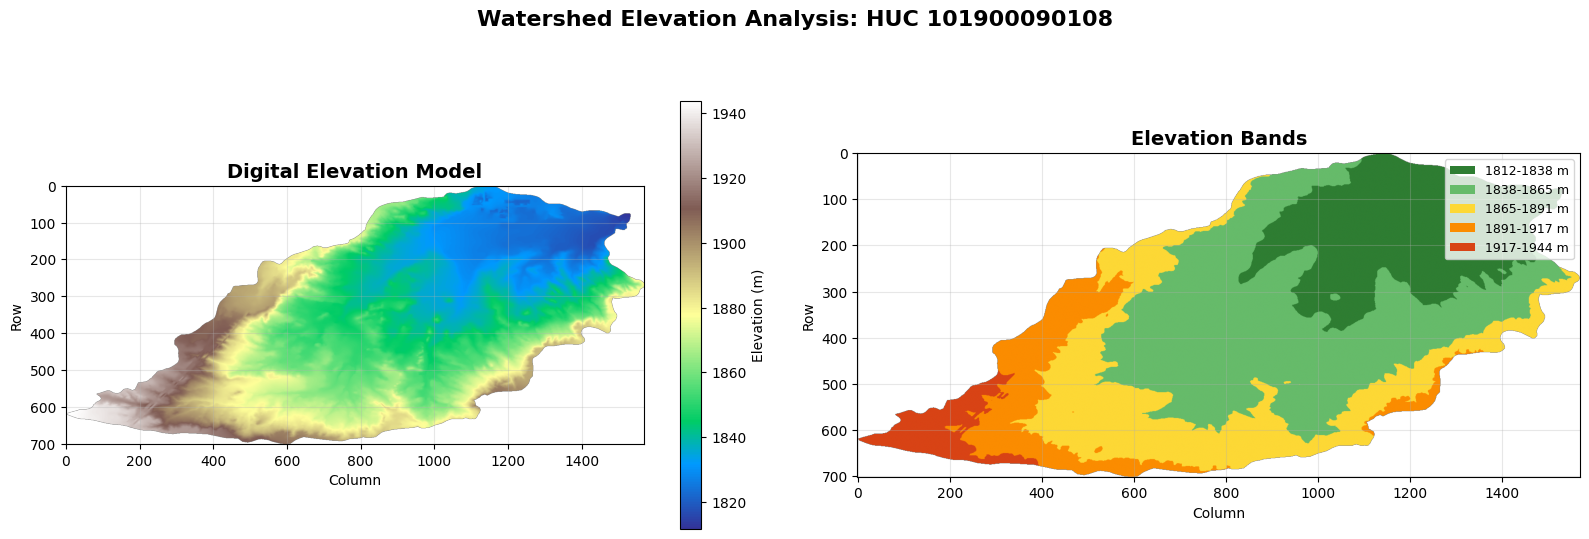

In [22]:
# Create elevation visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Continuous elevation
im1 = ax1.imshow(dem_clipped_masked, cmap='terrain', aspect='equal')
plt.colorbar(im1, ax=ax1, label='Elevation (m)', shrink=0.8)
ax1.set_title('Digital Elevation Model', fontsize=14, fontweight='bold')
ax1.set_xlabel('Column')
ax1.set_ylabel('Row')
ax1.grid(True, alpha=0.3)

# Right: Elevation bands
colors_bands = ['#2E7D32', '#66BB6A', '#FDD835', '#FB8C00', '#D84315']  # Green to red
cmap_bands = ListedColormap(colors_bands[:n_bands])
im2 = ax2.imshow(np.ma.masked_where(elevation_bands == 0, elevation_bands),
                 cmap=cmap_bands, aspect='equal', vmin=1, vmax=n_bands)

# Create custom legend for bands
legend_elements = [mpatches.Patch(facecolor=colors_bands[i],
                                  label=f'{band_edges[i]:.0f}-{band_edges[i+1]:.0f} m')
                  for i in range(n_bands)]
ax2.legend(handles=legend_elements, loc='upper right', fontsize=9)

ax2.set_title('Elevation Bands', fontsize=14, fontweight='bold')
ax2.set_xlabel('Column')
ax2.set_ylabel('Row')
ax2.grid(True, alpha=0.3)

plt.suptitle(f'Watershed Elevation Analysis: HUC {target_huc}',
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Part 9: Land Cover Analysis 🌿

### Calculate Land Cover Statistics

In [23]:
# Calculate land cover statistics
print("LAND COVER STATISTICS FOR WATERSHED")
print("="*60)

# Get unique values and counts
unique_lc, counts_lc = np.unique(nlcd_clipped_data[nlcd_clipped_data > 0], return_counts=True)

# Calculate areas (assuming 30m resolution for NLCD)
pixel_area_nlcd = 30 * 30  # square meters
total_pixels = counts_lc.sum()
total_area_km2 = (total_pixels * pixel_area_nlcd) / 1_000_000

# Create summary table
lc_stats = []

for value, count in zip(unique_lc, counts_lc):
    area_km2 = (count * pixel_area_nlcd) / 1_000_000
    percentage = (count / total_pixels) * 100

    lc_stats.append({
        'Code': value,
        'Class': nlcd_classes.get(value, 'Unknown'),
        'Pixels': count,
        'Area_km2': area_km2,
        'Percent': percentage
    })

# Create DataFrame and sort by area
lc_df = pd.DataFrame(lc_stats)
lc_df = lc_df.sort_values('Area_km2', ascending=False)

print(f"Total watershed area: {total_area_km2:.2f} km²\n")
print(lc_df.to_string(index=False))

LAND COVER STATISTICS FOR WATERSHED
Total watershed area: 48.64 km²

 Code                        Class  Pixels  Area_km2   Percent
   71         Grassland/Herbaceous   35912   32.3208 66.449560
   22     Developed, Low Intensity    9372    8.4348 17.341426
   23  Developed, Medium Intensity    4109    3.6981  7.603064
   21        Developed, Open Space    3042    2.7378  5.628747
   31                  Barren Land     533    0.4797  0.986233
   24    Developed, High Intensity     448    0.4032  0.828954
   95 Emergent Herbaceous Wetlands     430    0.3870  0.795648
   82             Cultivated Crops     110    0.0990  0.203538
   81                  Pasture/Hay      72    0.0648  0.133225
   11                   Open Water      14    0.0126  0.025905
   52                  Shrub/Scrub       2    0.0018  0.003701


### Visualize Land Cover

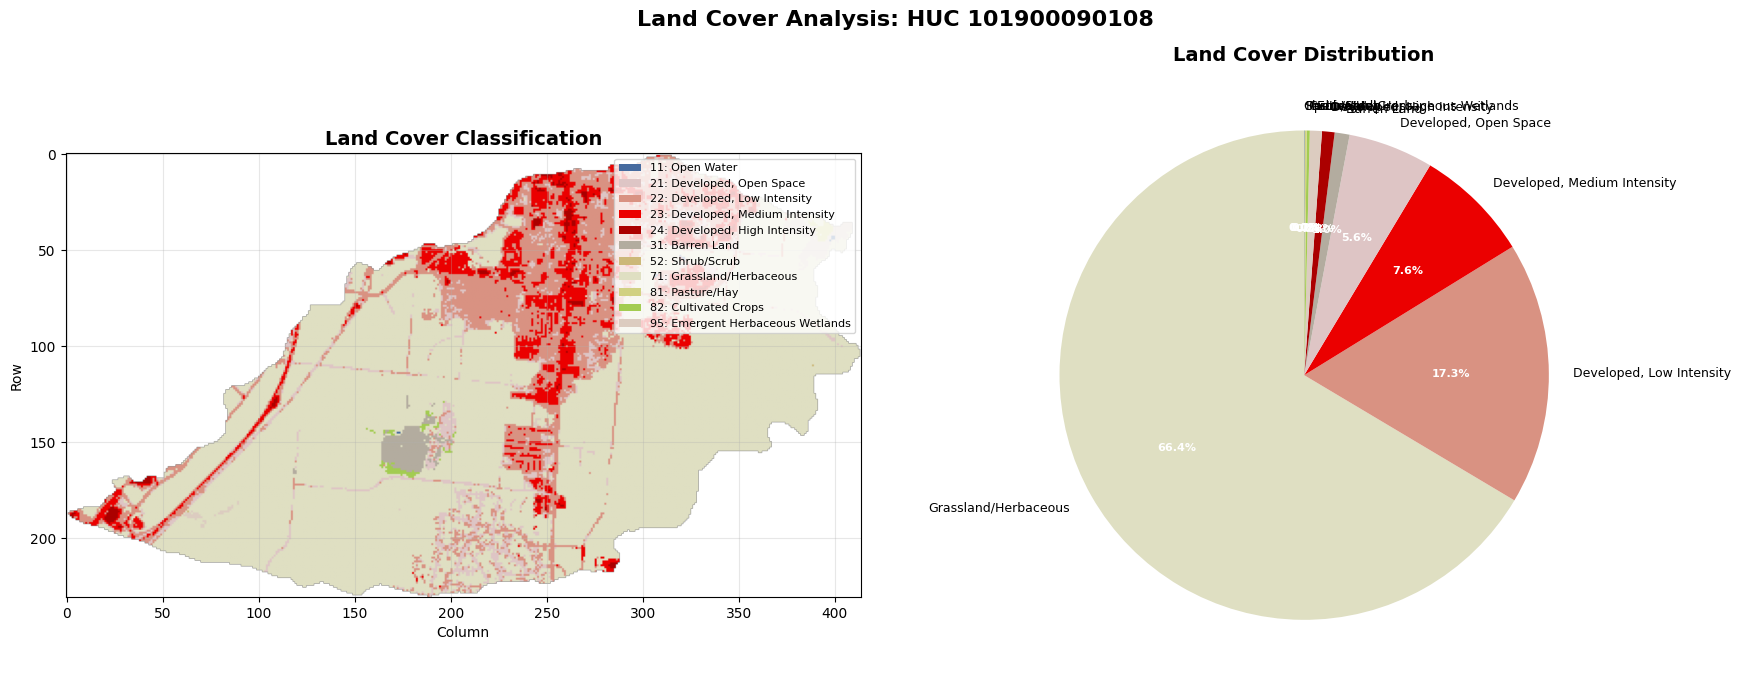

In [24]:
# Create land cover map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Left: Land cover map
# Create custom colormap for NLCD classes
unique_in_watershed = nlcd_clipped_data[nlcd_clipped_data > 0].flatten()
unique_classes = np.unique(unique_in_watershed)

# Create display version with sequential values
nlcd_display = np.zeros_like(nlcd_clipped_data)
color_list = []
labels_list = []

for i, class_val in enumerate(unique_classes):
    nlcd_display[nlcd_clipped_data == class_val] = i + 1
    color_list.append(nlcd_colors.get(class_val, '#808080'))
    labels_list.append(f"{class_val}: {nlcd_classes.get(class_val, 'Unknown')}")

cmap_nlcd = ListedColormap(color_list)
im = ax1.imshow(np.ma.masked_where(nlcd_display == 0, nlcd_display),
                cmap=cmap_nlcd, vmin=1, vmax=len(unique_classes))

# Create legend
legend_elements = [mpatches.Patch(facecolor=color_list[i],
                                  label=labels_list[i])
                  for i in range(len(unique_classes))]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=8)

ax1.set_title('Land Cover Classification', fontsize=14, fontweight='bold')
ax1.set_xlabel('Column')
ax1.set_ylabel('Row')
ax1.grid(True, alpha=0.3)

# Right: Land cover distribution pie chart
colors_pie = [nlcd_colors.get(code, '#808080') for code in lc_df['Code']]
wedges, texts, autotexts = ax2.pie(lc_df['Percent'],
                                    labels=lc_df['Class'],
                                    colors=colors_pie,
                                    autopct='%1.1f%%',
                                    startangle=90)

# Improve text readability
for text in texts:
    text.set_fontsize(9)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(8)

ax2.set_title('Land Cover Distribution', fontsize=14, fontweight='bold')

plt.suptitle(f'Land Cover Analysis: HUC {target_huc}',
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Part 10: Slope Analysis 🏔️

Calculate slope from DEM for runoff analysis:

In [25]:
# Calculate slope using numpy gradient
# Note: This is a simplified calculation
pixel_size = 10  # meters (adjust based on actual DEM resolution)

# Calculate gradients
dz_dx, dz_dy = np.gradient(dem_clipped_masked, pixel_size)

# Calculate slope in degrees
slope_radians = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
slope_degrees = np.degrees(slope_radians)

# Mask invalid values
slope_degrees = np.ma.masked_array(slope_degrees, mask=dem_clipped_masked.mask)

# Calculate slope statistics
valid_slopes = slope_degrees[~slope_degrees.mask]

print("SLOPE STATISTICS")
print("="*40)
print(f"Minimum slope: {valid_slopes.min():.1f}°")
print(f"Maximum slope: {valid_slopes.max():.1f}°")
print(f"Mean slope: {valid_slopes.mean():.1f}°")
print(f"Median slope: {np.median(valid_slopes):.1f}°")

# Classify slopes for H&H analysis
print("\nSLOPE CLASSES FOR RUNOFF")
print("="*40)
flat = (valid_slopes < 2).sum() / len(valid_slopes) * 100
gentle = ((valid_slopes >= 2) & (valid_slopes < 5)).sum() / len(valid_slopes) * 100
moderate = ((valid_slopes >= 5) & (valid_slopes < 15)).sum() / len(valid_slopes) * 100
steep = ((valid_slopes >= 15) & (valid_slopes < 30)).sum() / len(valid_slopes) * 100
very_steep = (valid_slopes >= 30).sum() / len(valid_slopes) * 100

print(f"Flat (< 2°): {flat:.1f}%")
print(f"Gentle (2-5°): {gentle:.1f}%")
print(f"Moderate (5-15°): {moderate:.1f}%")
print(f"Steep (15-30°): {steep:.1f}%")
print(f"Very steep (> 30°): {very_steep:.1f}%")

SLOPE STATISTICS
Minimum slope: 0.0°
Maximum slope: 24.0°
Mean slope: 2.2°
Median slope: 1.4°

SLOPE CLASSES FOR RUNOFF
Flat (< 2°): 62.5%
Gentle (2-5°): 27.9%
Moderate (5-15°): 9.5%
Steep (15-30°): 0.1%
Very steep (> 30°): 0.0%


### Visualize Slope

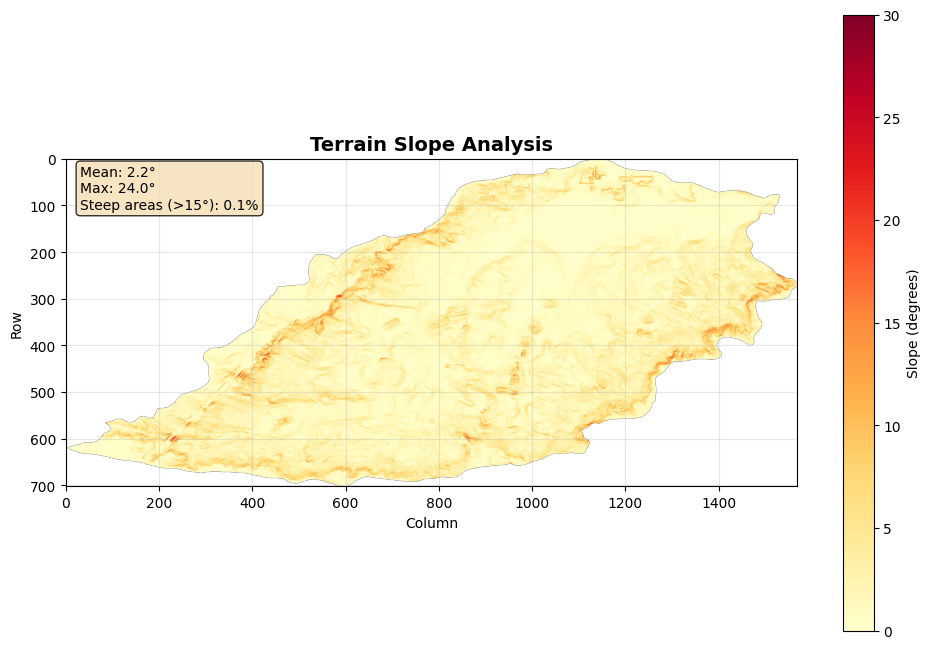

In [26]:
# Visualize slope
fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(slope_degrees, cmap='YlOrRd', aspect='equal', vmin=0, vmax=30)
plt.colorbar(im, ax=ax, label='Slope (degrees)', shrink=0.8)

ax.set_title('Terrain Slope Analysis', fontsize=14, fontweight='bold')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
ax.grid(True, alpha=0.3)

# Add text with key statistics
textstr = f'Mean: {valid_slopes.mean():.1f}°\n' \
          f'Max: {valid_slopes.max():.1f}°\n' \
          f'Steep areas (>15°): {(steep + very_steep):.1f}%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

## Part 11: H&H Applications - Curve Numbers 💧

Assign SCS Curve Numbers based on land cover:

In [27]:
# SCS Curve Numbers for Hydrologic Soil Group B (adjust as needed)
# These are typical values - adjust based on local conditions
cn_lookup = {
    11: 100,  # Open Water
    12: 100,  # Ice/Snow
    21: 61,   # Developed, Open Space
    22: 75,   # Developed, Low Intensity
    23: 83,   # Developed, Medium Intensity
    24: 93,   # Developed, High Intensity
    31: 77,   # Barren Land
    41: 55,   # Deciduous Forest
    42: 55,   # Evergreen Forest
    43: 55,   # Mixed Forest
    52: 48,   # Shrub/Scrub
    71: 65,   # Grassland
    81: 69,   # Pasture/Hay
    82: 75,   # Cultivated Crops
    90: 85,   # Woody Wetlands
    95: 85    # Herbaceous Wetlands
}

# Calculate weighted curve number
total_cn_area = 0
total_area = 0

print("CURVE NUMBER ANALYSIS")
print("="*60)
print(f"{'Land Cover':<30} {'Area (km²)':<10} {'CN':<5} {'Weighted':<10}")
print("-"*60)

for _, row in lc_df.iterrows():
    cn = cn_lookup.get(row['Code'], 70)  # Default CN of 70
    weighted = row['Area_km2'] * cn
    total_cn_area += weighted
    total_area += row['Area_km2']

    print(f"{row['Class']:<30} {row['Area_km2']:<10.2f} {cn:<5} {weighted:<10.1f}")

# Calculate composite CN
composite_cn = total_cn_area / total_area if total_area > 0 else 0

print("-"*60)
print(f"{'COMPOSITE CURVE NUMBER:':<30} {'':<10} {composite_cn:<5.1f}")
print("\n💡 This CN can be used for runoff calculations in HEC-HMS or similar models")

CURVE NUMBER ANALYSIS
Land Cover                     Area (km²) CN    Weighted  
------------------------------------------------------------
Grassland/Herbaceous           32.32      65    2100.9    
Developed, Low Intensity       8.43       75    632.6     
Developed, Medium Intensity    3.70       83    306.9     
Developed, Open Space          2.74       61    167.0     
Barren Land                    0.48       77    36.9      
Developed, High Intensity      0.40       93    37.5      
Emergent Herbaceous Wetlands   0.39       85    32.9      
Cultivated Crops               0.10       75    7.4       
Pasture/Hay                    0.06       69    4.5       
Open Water                     0.01       100   1.3       
Shrub/Scrub                    0.00       48    0.1       
------------------------------------------------------------
COMPOSITE CURVE NUMBER:                   68.4 

💡 This CN can be used for runoff calculations in HEC-HMS or similar models


## Part 12: Professional Integrated Map 🎨

Create a comprehensive map combining all analyses:

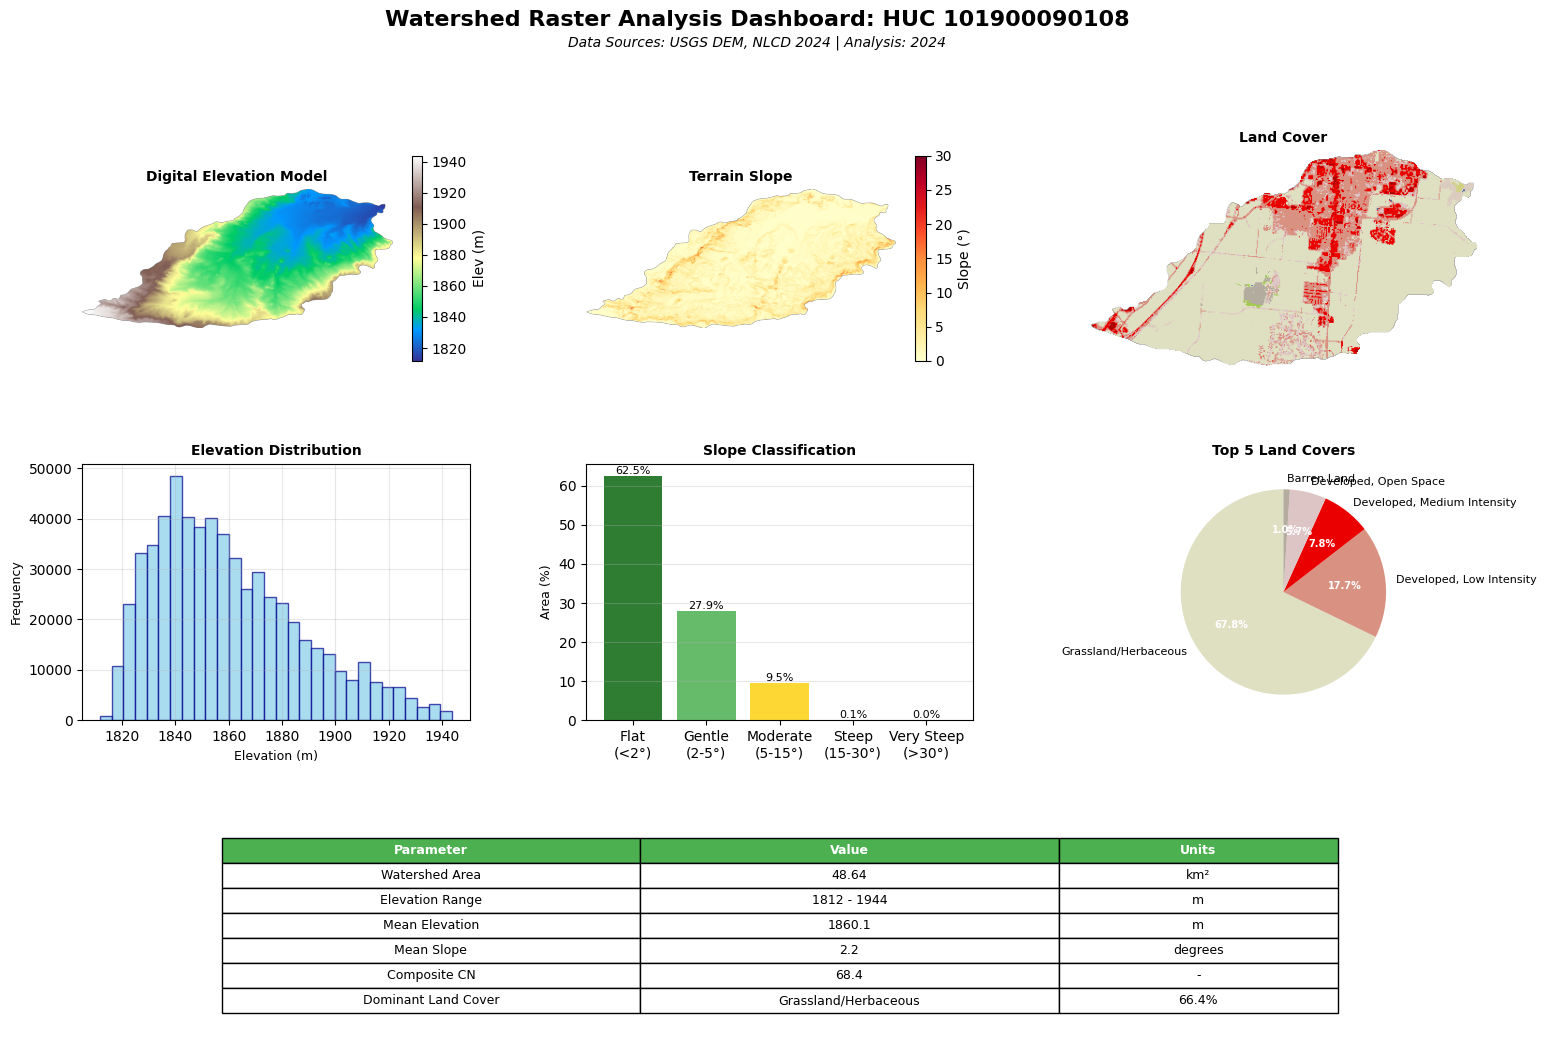

✅ Professional integrated analysis map created!


In [28]:
# Create professional integrated visualization
fig = plt.figure(figsize=(18, 12))

# Create grid for subplots
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. DEM
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(dem_clipped_masked, cmap='terrain', aspect='equal')
plt.colorbar(im1, ax=ax1, label='Elev (m)', shrink=0.8)
ax1.set_title('Digital Elevation Model', fontsize=10, fontweight='bold')
ax1.axis('off')

# 2. Slope
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(slope_degrees, cmap='YlOrRd', aspect='equal', vmin=0, vmax=30)
plt.colorbar(im2, ax=ax2, label='Slope (°)', shrink=0.8)
ax2.set_title('Terrain Slope', fontsize=10, fontweight='bold')
ax2.axis('off')

# 3. Land Cover
ax3 = fig.add_subplot(gs[0, 2])
im3 = ax3.imshow(np.ma.masked_where(nlcd_display == 0, nlcd_display),
                cmap=cmap_nlcd, vmin=1, vmax=len(unique_classes))
ax3.set_title('Land Cover', fontsize=10, fontweight='bold')
ax3.axis('off')

# 4. Elevation Histogram
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(valid_elevations, bins=30, color='skyblue', edgecolor='darkblue', alpha=0.7)
ax4.set_xlabel('Elevation (m)', fontsize=9)
ax4.set_ylabel('Frequency', fontsize=9)
ax4.set_title('Elevation Distribution', fontsize=10, fontweight='bold')
ax4.grid(True, alpha=0.3)

# 5. Slope Classes Bar Chart
ax5 = fig.add_subplot(gs[1, 1])
slope_classes = ['Flat\n(<2°)', 'Gentle\n(2-5°)', 'Moderate\n(5-15°)',
                 'Steep\n(15-30°)', 'Very Steep\n(>30°)']
slope_percentages = [flat, gentle, moderate, steep, very_steep]
bars = ax5.bar(slope_classes, slope_percentages,
               color=['#2E7D32', '#66BB6A', '#FDD835', '#FB8C00', '#D84315'])
ax5.set_ylabel('Area (%)', fontsize=9)
ax5.set_title('Slope Classification', fontsize=10, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')
for bar, pct in zip(bars, slope_percentages):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{pct:.1f}%', ha='center', fontsize=8)

# 6. Land Cover Pie Chart
ax6 = fig.add_subplot(gs[1, 2])
top_5 = lc_df.head(5)
colors_pie = [nlcd_colors.get(code, '#808080') for code in top_5['Code']]
wedges, texts, autotexts = ax6.pie(top_5['Percent'],
                                    labels=top_5['Class'],
                                    colors=colors_pie,
                                    autopct='%1.1f%%',
                                    startangle=90)
for text in texts:
    text.set_fontsize(8)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(7)
ax6.set_title('Top 5 Land Covers', fontsize=10, fontweight='bold')

# 7. Summary Statistics Table
ax7 = fig.add_subplot(gs[2, :])
ax7.axis('tight')
ax7.axis('off')

# Create summary data
summary_data = [
    ['Parameter', 'Value', 'Units'],
    ['Watershed Area', f'{total_area_km2:.2f}', 'km²'],
    ['Elevation Range', f'{valid_elevations.min():.0f} - {valid_elevations.max():.0f}', 'm'],
    ['Mean Elevation', f'{valid_elevations.mean():.1f}', 'm'],
    ['Mean Slope', f'{valid_slopes.mean():.1f}', 'degrees'],
    ['Composite CN', f'{composite_cn:.1f}', '-'],
    ['Dominant Land Cover', lc_df.iloc[0]['Class'], f"{lc_df.iloc[0]['Percent']:.1f}%"]
]

table = ax7.table(cellText=summary_data[1:], colLabels=summary_data[0],
                 cellLoc='center', loc='center',
                 colWidths=[0.3, 0.3, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

# Style header row
for i in range(3):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Main title
fig.suptitle(f'Watershed Raster Analysis Dashboard: HUC {target_huc}',
            fontsize=16, fontweight='bold', y=0.98)

# Add subtitle with date and data sources
fig.text(0.5, 0.95, 'Data Sources: USGS DEM, NLCD 2024 | Analysis: 2024',
        ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.show()

print("✅ Professional integrated analysis map created!")

## Practice Exercises 🎯

### Exercise 1: Multi-Watershed Raster Analysis
Analyze elevation and land cover for 3 different watersheds.

In [ ]:
# EXERCISE 1: Compare raster statistics across watersheds
# Your code here:

# Step 1: Select 3 watersheds

# Step 2: For each, clip DEM and NLCD

# Step 3: Calculate statistics

# Step 4: Create comparison table


### Exercise 2: Aspect Analysis
Calculate and visualize terrain aspect (direction of slope).

In [ ]:
# EXERCISE 2: Calculate aspect from DEM
# Your code here:

# Hint: Use np.arctan2(dz_dy, dz_dx)
# Convert to degrees and classify (N, NE, E, SE, S, SW, W, NW)


### Exercise 3: Elevation-Land Cover Relationship
Analyze how land cover varies with elevation.

In [ ]:
# EXERCISE 3: Land cover by elevation band
# Your code here:

# Step 1: Create elevation bands

# Step 2: For each band, extract land cover

# Step 3: Calculate dominant land cover per band

# Step 4: Visualize results


### Exercise 4: Runoff Potential Map
Create a map combining slope and land cover to show runoff potential.

In [ ]:
# EXERCISE 4: Runoff potential analysis
# Your code here:

# Combine high slopes + high CN areas
# Create risk categories (Low, Medium, High)
# Visualize as a new raster


## 🎉 What You Can Now Do!

Congratulations! You've completed Module 4 and now have a complete spatial analysis toolkit.

### ✅ You Can Now:

**Raster Data Management:**
- Load and explore DEMs and land cover data
- Understand resolution, bands, and NoData
- Clip rasters to areas of interest
- Reproject between coordinate systems

**Terrain Analysis:**
- Calculate elevation statistics
- Generate slope and aspect maps
- Create elevation bands
- Identify steep areas for erosion risk

**Land Cover Analysis:**
- Classify and quantify land uses
- Calculate composite curve numbers
- Assess imperviousness
- Link land cover to runoff potential

**Integrated Analysis:**
- Combine vector watersheds with raster data
- Perform zonal statistics
- Create professional dashboard maps
- Generate H&H model inputs

### 🚀 Complete Spatial Toolkit Achieved!

**Module 3 (Vector)** + **Module 4 (Raster)** = **Full spatial analysis capability**

You can now:
- Define WHERE (vector boundaries)
- Analyze WHAT'S THERE (raster surfaces)
- Understand HOW water moves (terrain)
- Predict runoff response (land cover)

### 💡 Key Takeaways:

1. **Rasters are grids of values** - perfect for continuous phenomena
2. **Resolution matters** - balance detail with file size
3. **CRS alignment is critical** - always check and match
4. **Combine analyses** - terrain + land cover = runoff understanding
5. **Visualize effectively** - maps communicate your analysis

### 📚 Your Raster Analysis Toolkit:

```python
# Essential raster operations
rasterio.open()          # Load raster
src.read()              # Read data
mask()                  # Clip to boundary
np.gradient()           # Calculate slope
zonal_stats()           # Statistics by zone
plt.imshow()            # Visualize
```

### 🌉 What's Next?

With your complete spatial toolkit, you can now:
- Build watershed models with accurate parameters
- Assess flood risk with terrain and land use data
- Create professional maps for reports
- Automate spatial analysis workflows

**The foundation is complete - now apply it to real H&H projects!** 🌊🗺️🐍